# Visualize result of Boids model

In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation, rc
from IPython.display import HTML

try:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif", size=10)
except:
    pass

## Set target result


In [ ]:
RES_DIR = "results/boid/"  # the directory where the results are saved
IDX = 1
NUM_CASES = 10
RES_DIR_SINGLE = f"{RES_DIR}test_{IDX}/"
MODELS = ["projection", "hamiltonian", "singlempnn"]
LABELS = {
    "projection": "Projection",
    "hamiltonian": "Hamiltonian",
    "singlempnn": "S-MPNN",
}
MARKERS = ["^", "v", "*"]
SAVE = True

# Visualize all data loss

## Load and process data


In [3]:
final_errors = {}
best_errors = {}
for m in MODELS:
    final_errors[m] = []
    best_errors[m] = []
for i in range(NUM_CASES):
    res_dir = f"{RES_DIR}test_{i+1}/"
    for m in MODELS:
        gt = np.load(f"{res_dir}data_test.npy")
        final_errors[m].append(
            np.mean((gt - np.load(f"{res_dir}{m}/final_prediction.npy")) ** 2)
        )
        best_errors[m].append(
            np.mean((gt - np.load(f"{res_dir}{m}/best_prediction.npy")) ** 2)
        )
for m in MODELS:
    final_errors[m] = np.array(final_errors[m])
    best_errors[m] = np.array(best_errors[m])

## Plot errors


In [4]:
def plot_all_errors(errors, title=None, finite_order=None):
    finite_value = None if finite_order is None else 10**finite_order
    fig, ax = plt.subplots(1, 1, figsize=(3.6, 3.0))
    if title is not None:
        ax.set_title(title)
    maximum = 0.0
    minimum = np.inf
    for m in MODELS:
        maximum = np.max([maximum, np.max(errors[m][errors[m] < np.inf])])
        minimum = np.min([minimum, np.min(errors[m][errors[m] < np.inf])])
    if finite_value is not None:
        maximum = np.min([maximum, finite_value])
    scale = maximum / minimum
    log_scale = np.log10(scale)
    inf_plot_value = maximum * 10 ** (int(log_scale * 0.1))
    ax.set_ylim(
        minimum / 10 ** (log_scale * 0.1),
        inf_plot_value * 10 ** (log_scale * 0.1),
    )
    for i, m in enumerate(MODELS):
        if finite_value is not None:
            inf_mask = (errors[m] > finite_value) | np.isnan(errors[m])
        else:
            inf_mask = np.isnan(errors[m])
        errors[m][inf_mask] = inf_plot_value
        plt.plot(
            range(1, len(errors[m]) + 1),
            errors[m],
            label=LABELS[m],
            color=f"C{i}",
            linestyle="--",
        )
        if not np.all(inf_mask):
            plt.scatter(
                np.arange(1, len(errors[m]) + 1)[~inf_mask],
                errors[m][~inf_mask],
                marker=MARKERS[i % len(MARKERS)],
                color=f"C{i}",
            )
        if np.any(inf_mask):
            plt.scatter(
                np.arange(1, len(errors[m]) + 1)[inf_mask],
                errors[m][inf_mask],
                marker="X",
                color=f"C{i}",
            )
    if finite_value is not None:
        ax.scatter([], [], marker="X", label=rf"$>10^{finite_order}$", color="black")
    else:
        ax.scatter([], [], marker="X", label="Inf", color="black")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.set_xlabel("Case")
    ax.set_xticks(range(1, NUM_CASES + 1))
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    return fig

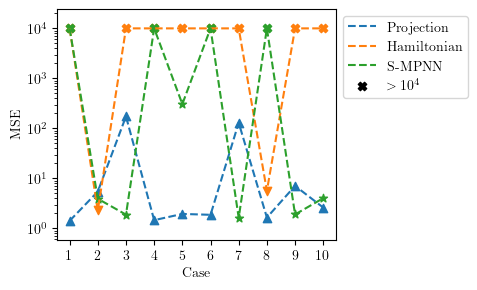

In [5]:
fig = plot_all_errors(final_errors, finite_order=4)
if SAVE:
    fig.savefig(f"{RES_DIR}final_errors.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show(fig)

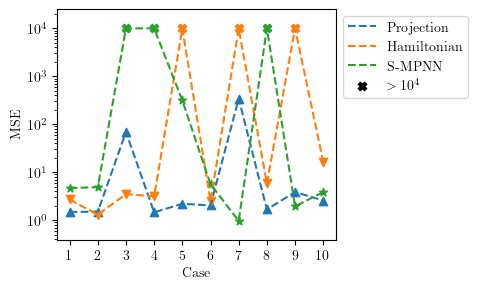

In [6]:
ax = plot_all_errors(best_errors, finite_order=4)
if SAVE:
    plt.savefig(f"{RES_DIR}best_errors.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show(ax)

# Visualize single data

## Load data


In [7]:
ground_truth = np.load(f"{RES_DIR_SINGLE}data_test.npy")
histories = {}
final_predictions = {}
best_predictions = {}
for m in MODELS:
    histories[m] = np.load(f"{RES_DIR_SINGLE}{m}/history.npy", allow_pickle=True).item()
    final_predictions[m] = np.load(f"{RES_DIR_SINGLE}{m}/final_prediction.npy")
    best_predictions[m] = np.load(f"{RES_DIR_SINGLE}{m}/best_prediction.npy")

## Plot training loss


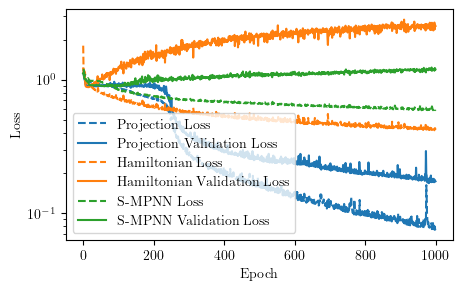

In [8]:
fig, ax = plt.subplots(figsize=(5.0, 3.0))
for i, m in enumerate(MODELS):
    ax.plot(
        histories[m]["train_loss"],
        label=f"{LABELS[m]} Loss",
        color=f"C{i}",
        linestyle="--",
    )
    ax.plot(
        histories[m]["val_loss"], label=f"{LABELS[m]} Validation Loss", color=f"C{i}"
    )
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_title("Training and validation loss")
if SAVE:
    plt.savefig(f"{RES_DIR_SINGLE}loss.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

## Plot prediction error (MSE)


In [9]:
final_errors = {}
best_errors = {}
for m in MODELS:
    final_errors[m] = np.mean(
        (final_predictions[m] - ground_truth)[:, :, :, :2] ** 2, axis=(2, 3)
    )
    best_errors[m] = np.mean(
        (best_predictions[m] - ground_truth)[:, :, :, :2] ** 2, axis=(2, 3)
    )


def plot_long_term_errors(errors, title=None, err_max=None) -> plt.Axes:
    fig, ax = plt.subplots(figsize=(5.0, 4.0))
    if err_max is not None:
        ax.set_ylim(0, err_max)
    for i, m in enumerate(MODELS):
        ax.fill_between(
            np.arange(errors[m].shape[1]),
            errors[m].min(axis=0),
            errors[m].max(axis=0),
            alpha=0.2,
            color=f"C{i}",
        )
        ax.plot(errors[m].mean(axis=0), label=LABELS[m], color=f"C{i}")
    ax.legend(loc="upper left")
    ax.set_xlabel("Time step")
    ax.set_ylabel("MSE")
    if title is not None:
        ax.set_title(title)
    return fig

- Final model


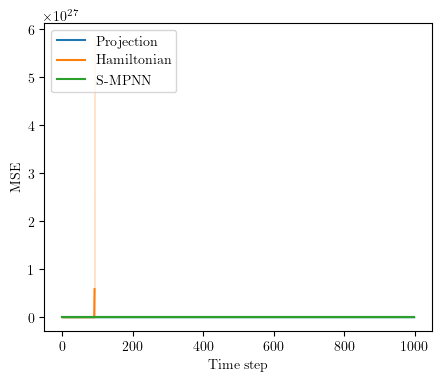

In [10]:
ax = plot_long_term_errors(final_errors)
if SAVE:
    plt.savefig(
        f"{RES_DIR_SINGLE}final_error.pdf", bbox_inches="tight", pad_inches=0.05
    )
plt.show(ax)

- Best model


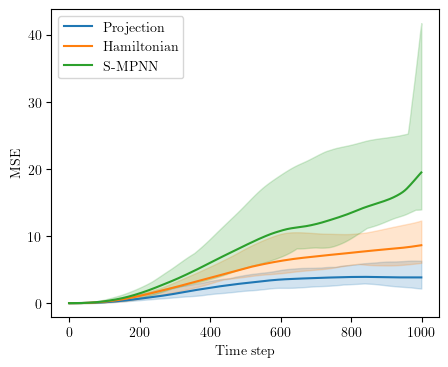

In [11]:
ax = plot_long_term_errors(best_errors)
if SAVE:
    plt.savefig(f"{RES_DIR_SINGLE}best_error.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show(ax)

## Plot prediction


In [12]:
def plot_prediction(
    result,
    interval,
    graph=None,
    dt=0.01,
    margin=1,
    gt=None,
    lims=None,
    size=None,
    boundary=None,
    legend="out",
):
    dot_conf = {
        "pred": {
            "c": "tab:blue",
            "s": 15,
            "edgecolors": "black",
            "linewidths": 0.2,
            "label": "Prediction",
        },
        "gt": {
            "c": "tab:orange",
            "s": 15,
            "edgecolors": "black",
            "linewidths": 0.2,
            "label": "Ground truth",
        },
    }
    boundary_line = (
        None
        if boundary is None
        else [
            [
                boundary[0, 0],
                boundary[0, 1],
                boundary[0, 1],
                boundary[0, 0],
                boundary[0, 0],
            ],
            [
                boundary[1, 0],
                boundary[1, 0],
                boundary[1, 1],
                boundary[1, 1],
                boundary[1, 0],
            ],
        ]
    )
    length = result.shape[0]
    num_plot = length // interval + 1
    x_lim = (
        (np.min(result[:, :, 0]) - margin, np.max(result[:, :, 0]) + margin)
        if lims is None
        else lims[0]
    )
    y_lim = (
        (np.min(result[:, :, 1]) - margin, np.max(result[:, :, 1]) + margin)
        if lims is None
        else lims[1]
    )
    fig, axes = plt.subplots(
        num_plot // 2 + num_plot % 2, 2, figsize=size, layout="constrained"
    )
    if num_plot % 2 == 1:
        axes[-1, 1].axis("off")
    for k in range(num_plot):
        row, col = k // 2, k % 2
        axes[row, col].set_xlim(x_lim)
        axes[row, col].set_ylim(y_lim)
        axes[row, col].set_aspect("equal")
        if k < num_plot - 1:
            if gt is not None:
                axes[row, col].scatter(
                    gt[k * interval, :, 0],
                    gt[k * interval, :, 1],
                    **dot_conf["gt"],
                )
            axes[row, col].set_title(rf"$t = {k * interval * dt:.2f}$")
            axes[row, col].scatter(
                result[k * interval, :, 0],
                result[k * interval, :, 1],
                **dot_conf["pred"],
            )
            if boundary is not None:
                axes[row, col].plot(*boundary_line, c="k")
        else:
            if gt is not None:
                axes[row, col].scatter(gt[-1, :, 0], gt[-1, :, 1], **dot_conf["gt"])
            axes[row, col].set_title(rf"$t = {(length-1) * dt:.2f}$")
            axes[row, col].scatter(
                result[-1, :, 0],
                result[-1, :, 1],
                **dot_conf["pred"],
            )
            if boundary is not None:
                axes[row, col].plot(*boundary_line, c="k")
            if legend == "out":
                if num_plot % 2 == 1:
                    axes[-1, 1].axis("off")
                    axes[-1, 1].scatter([], [], **dot_conf["gt"])
                    axes[-1, 1].scatter([], [], **dot_conf["pred"])
                    axes[-1, 1].legend(loc="center")
                else:
                    axes[row, col].legend(loc="lower center", bbox_to_anchor=(1, 0.5))
            if legend == "in":
                axes[0, 0].legend()
    return fig


def plot_prediction_colmun(
    result,
    interval,
    graph=None,
    dt=0.01,
    margin=1,
    gt=None,
    lims=None,
    size=None,
    boundary=None,
    legend="out",
):
    dot_conf = {
        "pred": {
            "c": "tab:blue",
            "s": 15,
            "edgecolors": "black",
            "linewidths": 0.2,
            "label": "Prediction",
        },
        "gt": {
            "c": "tab:orange",
            "s": 15,
            "edgecolors": "black",
            "linewidths": 0.2,
            "label": "Ground truth",
        },
    }
    boundary_line = (
        None
        if boundary is None
        else [
            [
                boundary[0, 0],
                boundary[0, 1],
                boundary[0, 1],
                boundary[0, 0],
                boundary[0, 0],
            ],
            [
                boundary[1, 0],
                boundary[1, 0],
                boundary[1, 1],
                boundary[1, 1],
                boundary[1, 0],
            ],
        ]
    )
    length = result.shape[0]
    num_plot = length // interval + 1
    x_lim = (
        (np.min(result[:, :, 0]) - margin, np.max(result[:, :, 0]) + margin)
        if lims is None
        else lims[0]
    )
    y_lim = (
        (np.min(result[:, :, 1]) - margin, np.max(result[:, :, 1]) + margin)
        if lims is None
        else lims[1]
    )
    fig, axes = plt.subplots(1, num_plot, figsize=size, layout="constrained")
    if num_plot % 2 == 1:
        axes[-1, 1].axis("off")
    for k in range(num_plot):
        axes[k].tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
            bottom=False,
            left=False,
            right=False,
            top=False,
        )
        axes[k].set_xlim(x_lim)
        axes[k].set_ylim(y_lim)
        axes[k].set_aspect("equal")
        if k < num_plot - 1:
            if gt is not None:
                axes[k].scatter(
                    gt[k * interval, :, 0],
                    gt[k * interval, :, 1],
                    **dot_conf["gt"],
                )
            axes[k].set_title(rf"$t = {k * interval * dt:.2f}$")
            axes[k].scatter(
                result[k * interval, :, 0],
                result[k * interval, :, 1],
                **dot_conf["pred"],
            )
            if boundary is not None:
                axes[k].plot(*boundary_line, c="k")
        else:
            if gt is not None:
                axes[k].scatter(gt[-1, :, 0], gt[-1, :, 1], **dot_conf["gt"])
            axes[k].set_title(rf"$t = {(length-1) * dt:.2f}$")
            axes[k].scatter(
                result[-1, :, 0],
                result[-1, :, 1],
                **dot_conf["pred"],
            )
            if boundary is not None:
                axes[k].plot(*boundary_line, c="k")
            if legend == "out":
                if num_plot % 2 == 1:
                    axes[-1, 1].axis("off")
                    axes[-1, 1].scatter([], [], **dot_conf["gt"])
                    axes[-1, 1].scatter([], [], **dot_conf["pred"])
                    axes[-1, 1].legend(loc="center")
                else:
                    axes[k].legend(loc="lower center", bbox_to_anchor=(1, 0.5))
            if legend == "in":
                pass
                # axes[0].legend()

    return fig

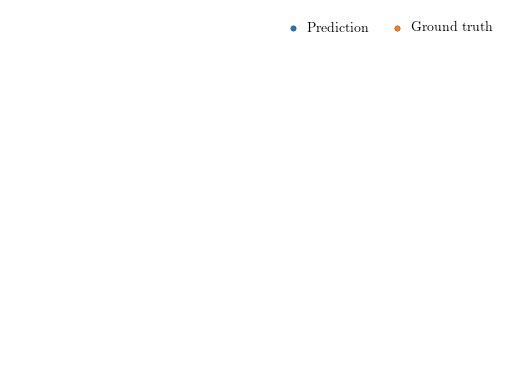

In [13]:
dot_conf = {
    "pred": {
        "c": "tab:blue",
        "s": 15,
        "edgecolors": "black",
        "linewidths": 0.2,
        "label": "Prediction",
    },
    "gt": {
        "c": "tab:orange",
        "s": 15,
        "edgecolors": "black",
        "linewidths": 0.2,
        "label": "Ground truth",
    },
}
fig, ax = plt.subplots()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.scatter([], [], **dot_conf["pred"])
ax.scatter([], [], **dot_conf["gt"])
legend = ax.legend(frameon=False, handletextpad=0, ncol=2, columnspacing=1)
legend_fig = legend.figure
legend_fig.canvas.draw()
bbox = legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted())
if SAVE:
    fig.savefig(f"{RES_DIR_SINGLE}legend.pdf", bbox_inches=bbox, pad_inches=0.05)

Projection


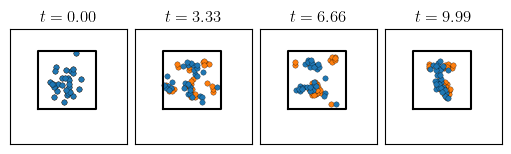

Hamiltonian


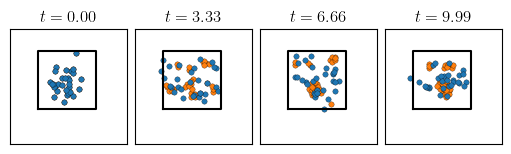

S-MPNN


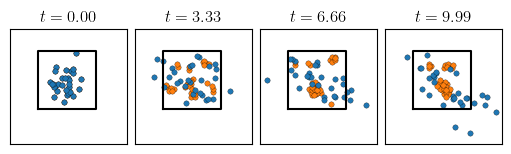

In [14]:
lim = (
    (np.min(ground_truth[:, :, 0]), np.max(ground_truth[:, :, 0])),
    (np.min(ground_truth[:, :, 1]), np.max(ground_truth[:, :, 1])),
)
for m in MODELS:
    lim = (
        np.min([lim[0][0], np.min(best_predictions[m][0, :, :, 0])]),
        np.max([lim[0][1], np.max(best_predictions[m][0, :, :, 0])]),
    ), (
        np.min([lim[1][0], np.min(best_predictions[m][0, :, :, 1])]),
        np.max([lim[1][1], np.max(best_predictions[m][0, :, :, 1])]),
    )
lim = ((lim[0][0] - 1, lim[0][1] + 1), (lim[1][0] - 1, lim[1][1] + 1))
for m in MODELS:
    print(LABELS[m])
    fig = plot_prediction_colmun(
        best_predictions[m][0],
        333,
        gt=ground_truth[0],
        lims=lim,
        size=(5, 4.5),
        boundary=np.array([[-5.0, 5.0], [-5.0, 5.0]]),
        legend="in",
    )
    if SAVE:
        plt.savefig(
            f"{RES_DIR_SINGLE}{m}_prediction.pdf", bbox_inches="tight", pad_inches=0.05
        )
    plt.show(fig)

## Animate prediction


In [15]:
def generate_animation_2d(res, gt=None, boundary=None):

    fig = plt.figure()
    if gt is None:
        min_x = np.min(res[:, :, 0])
        max_x = np.max(res[:, :, 0])
        min_y = np.min(res[:, :, 1])
        max_y = np.max(res[:, :, 1])
    else:
        min_x = np.min(np.concatenate((res[:, :, 0], gt[:, :, 0])))
        max_x = np.max(np.concatenate((res[:, :, 0], gt[:, :, 0])))
        min_y = np.min(np.concatenate((res[:, :, 1], gt[:, :, 1])))
        max_y = np.max(np.concatenate((res[:, :, 1], gt[:, :, 1])))
    if boundary is not None:
        min_x = min(min_x, boundary[0, 0])
        max_x = max(max_x, boundary[0, 1])
        min_y = min(min_y, boundary[1, 0])
        max_y = max(max_y, boundary[1, 1])
    ax = fig.add_subplot(
        111,
        autoscale_on=False,
        xlim=(min_x - 1.0, max_x + 1.0),
        ylim=(min_y - 1.0, max_y + 1.0),
    )
    ax.set_aspect("equal")
    fig.subplots_adjust(left=None, bottom=None, right=None, wspace=None, hspace=None)

    def update(i):
        ax.clear()
        ax.set_xlim(min_x - 1.0, max_x + 1.0)
        ax.set_ylim(min_y - 1.0, max_y + 1.0)
        if boundary is not None:
            ax.plot(
                [
                    boundary[0, 0],
                    boundary[0, 1],
                    boundary[0, 1],
                    boundary[0, 0],
                    boundary[0, 0],
                ],
                [
                    boundary[1, 0],
                    boundary[1, 0],
                    boundary[1, 1],
                    boundary[1, 1],
                    boundary[1, 0],
                ],
                c="k",
            )
        if gt is not None:
            ax.scatter(
                gt[i, :, 0],
                gt[i, :, 1],
                label="Ground Truth",
                c="tab:orange",
                alpha=1.0,
            )
        ax.scatter(
            res[i, :, 0], res[i, :, 1], label="Predicted", c="tab:blue", alpha=1.0
        )
        if gt is not None:
            ax.legend(loc="upper right")

    ani = animation.FuncAnimation(fig, update, frames=len(res), interval=10)
    return ani

- Prediction of each model


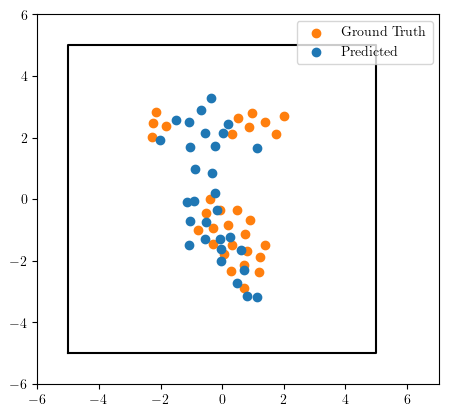

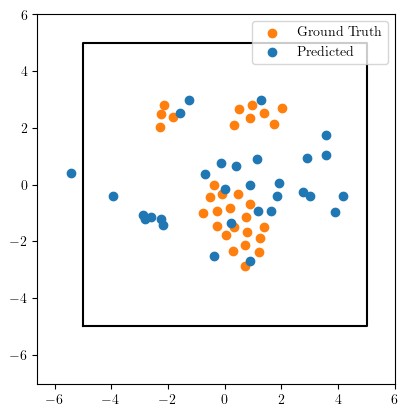

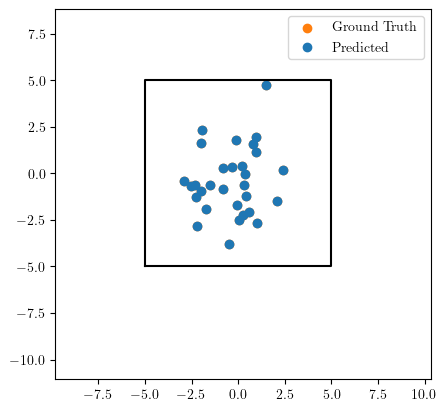

In [16]:
ani_html = ""
for m in MODELS:
    try:
        ani = generate_animation_2d(
            best_predictions[m][0],
            ground_truth[0],
            boundary=np.array([[-5.0, 5.0], [-5.0, 5.0]]),
        )
        if SAVE:
            ani.save(f"{RES_DIR_SINGLE}{m}_best.mp4", writer="ffmpeg")
        ani_html += f"<h2>{m} best</h2>" + HTML(ani.to_html5_video()).data
    except:
        print(f"Could not create animation for {m}.")
        continue
HTML(ani_html)

- Groundtruth


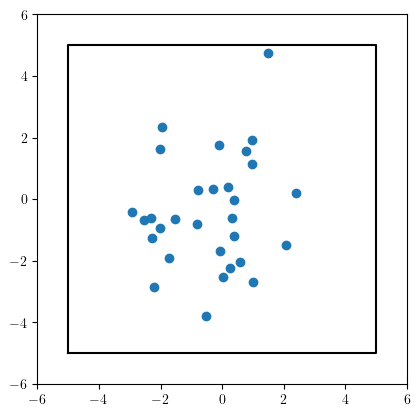

In [17]:
ani = generate_animation_2d(
    ground_truth[0], boundary=np.array([[-5.0, 5.0], [-5.0, 5.0]])
)
if SAVE:
    ani.save(f"{RES_DIR_SINGLE}ground_truth.mp4", writer="ffmpeg")
HTML(ani.to_html5_video())